Packages from: https://github.com/cwlkr/torchvahadane .

In the GitHub page, the author says that the packages works with Python 3.11.3 and SPAMS 2.6.5.4, which happens to be the latest version, as of today 07-01-2025.\
So, I'll use the environment `he_torchvahadane` which the relative version of Python and [SPAMS](https://pypi.org/project/spams/), installed via source code in the environment folder:\
```sh
git clone https://github.com/getspams/spams-python
cd spams-python
pip install -e .
```

After this, we can install the package for the real stain normalisation:\
```sh
pip install git+https://github.com/cwlkr/torchvahadane.git
```



#### Important!
Moreover, the original functions in this package presents some problem. After one day of debugging, I managed to solve the error.\
I recommend to open the `stain_extractor_gpu.py` file of the `torchvahadane` package and switch the code with the one contained in a file that I've personally coded (`new_stain_extractor_gpu.py`) located in this folder.

---
# 0. - Imports, paths and GPU devices

In [1]:
import os
import matplotlib.pyplot as plt
import subprocess
import torchvahadane
from torchvahadane import TorchVahadaneNormalizer
import torchvision.transforms.functional #as TF
from PIL import Image
import numpy as np
import torch
import torchvision
import cv2
import kornia
import random

Setting the working directory as the actual one.

In [2]:
os.chdir("/disk2/user/gabgam/work/gigi_env/the_project/2_image_normalisation/")
print(os.getcwd())

/disk2/work/gabgam/gigi_env/the_project/2_image_normalisation


Let's set CUDA's parameters. I select to work just on the second GPU (named "1").

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

Setting the paths and some variables.

In [4]:
normalisation_method = 'torch_vahadane'

# Set paths
INPUT_FOLDER = "../1_tiling/outputs/satac_C1/tiling_output/v3_allspots/tiles_100/"  # Replace with the path to your folder containing images
tiles_info = INPUT_FOLDER.split('/')

TARGET_IMAGE_PATH = "reference_images/reference_full.jpeg"
target_temp_path = "target_is_" + TARGET_IMAGE_PATH.split("/")[1].split(".")[0]
output_folder = f"./output/{tiles_info[3]}/{tiles_info[5]}/{tiles_info[6]}/{normalisation_method}/{target_temp_path}"
output_folder_gpu = os.path.join(output_folder, 'gpu')
print(output_folder)

# Let's create the output folder files
os.makedirs(output_folder_gpu, exist_ok=True)

./output/satac_C1/v3_allspots/tiles_100/torch_vahadane/target_is_reference_full


---
# 1. - Vahadane Normalisation
This normalisation .... bla bla bla... yapping

## 1.1 - Normalisation with GPU acceleration
Be careful, this run takes around 30 min. You can directly modify the `normaliser_torch_vahadane_gpu.py` script and launch it with the command line.

In [5]:
gpu = "cuda"
# Load and convert to NumPy array (for OpenCV compatibility)
target = Image.open(TARGET_IMAGE_PATH).convert("RGB")
target = torch.Tensor(np.array(target))  # Convert to PyTorch tensor

# Transpose dimensions to match Kornia's expected format
target = target.permute(2, 0, 1).to(gpu)

# Initialize the normalizer
normalizer = TorchVahadaneNormalizer(device=gpu,
                                     staintools_estimate=False
                                     )
normalizer.stain_extractor.luminosity_threshold = 0.9 # increasing the mask sensitivity. Normally is 0.8
normalizer.fit(target)  # Pass NumPy array for compatibility

# Log file for saving images' name that failed normalisation
normalisation_fails_file = f"{output_folder_gpu}/0_failed_to_normalise.txt" # 0 just for having the file listed as first

# Process each image in the input folder
with open(normalisation_fails_file, "w") as file:
    file.write("The following tiles haven't normalised:\n")

    for filename in os.listdir(INPUT_FOLDER):
        image_path = os.path.join(INPUT_FOLDER, 'gpu', filename)

        # Load and preprocess the image
        img = Image.open(image_path).convert("RGB")
        img = torch.Tensor(np.array(img))  # Convert to PyTorch tensor

        # Transpose dimensions to match Kornia's expected format
        img = img.permute(2, 0, 1).to(gpu)#.unsqueeze(0)

        try:
            # Normalization
            img_normed_tensor = normalizer.transform(img)

            # Convert the normalized image back to PIL format
            img_normed_pil = torchvision.transforms.functional.to_pil_image(img_normed_tensor)

            # Save
            output_path = os.path.join(output_folder_gpu, f"{os.path.splitext(filename)[0]}_{normalisation_method}_gpu.jpg")
            img_normed_pil.save(output_path)
        
        except Exception as e:
            file.write(f"{filename}\n")

torch.Size([3, 1327, 1269])
Shape of input I before processing: torch.Size([3, 1327, 1269])
Shape of input I after processing: torch.Size([3, 1327, 1269])
Shape of I_LAB after rgb_to_lab: torch.Size([1, 3, 1327, 1269])
Shape of L after squeezing: torch.Size([1327, 1269])
Shape of input I in get_stain_matrix: torch.Size([3, 1327, 1269])
Input shape for get_tissue_mask: torch.Size([3, 1327, 1269])
Initial mask shape: torch.Size([1683963])
OD shape before reshaping: torch.Size([3, 1327, 1269])
Mask shape after flattening: torch.Size([1683963]), OD shape after flattening: torch.Size([1683963, 3])
Shape of input I before processing: torch.Size([3, 688, 688])
Shape of input I after processing: torch.Size([3, 688, 688])
Shape of I_LAB after rgb_to_lab: torch.Size([1, 3, 688, 688])
Shape of L after squeezing: torch.Size([688, 688])
Shape of input I in get_stain_matrix: torch.Size([3, 688, 688])
Input shape for get_tissue_mask: torch.Size([3, 688, 688])
Initial mask shape: torch.Size([473344])


## 1.2 - Normalisation on CPU
This is ever slower; it takes about 1h and 10 mins. You can directly modify the `normaliser_torch_vahadane_cpu.py` script and launch it with the command line.

In [ ]:
# Load and preprocess the target image
target = Image.open(TARGET_IMAGE_PATH).convert("RGB")
target_array = np.array(target)  # Convert to NumPy array (for OpenCV compatibility)

# Initialize the normalizer
normalizer = TorchVahadaneNormalizer(device='cuda', staintools_estimate=True)
#normalizer.stain_extractor.luminosity_threshold = 0.9  # Increase mask sensitivity
normalizer.fit(target_array)  # Pass NumPy array for compatibility

normalisation_fails_file = f"{output_folder}/0_failed_to_normalise.txt" # 0 just for having the file listed as first

with open(normalisation_fails_file, "w") as file:
    file.write("The following are the tiles not normalised:\n")
    
    # Process each image in the input folder
    for filename in os.listdir(INPUT_FOLDER):
        image_path = os.path.join(INPUT_FOLDER, filename)

        # Load and preprocess the image
        img = Image.open(image_path).convert("RGB")
        img_array = np.array(img)  # Convert to NumPy array (for OpenCV compatibility)


        try:
            # Perform normalization
            img_normed_tensor = normalizer.transform(img_array, return_mask=False)
            
            # Convert the normalized tensor to a NumPy array
            img_normed_array = img_normed_tensor.cpu().numpy().clip(0, 255).astype(np.uint8)

            # Convert the normalized image back to PIL format
            img_normed_pil = Image.fromarray(img_normed_array)

            # Save the normalized image
            output_path = os.path.join(output_folder, f"{os.path.splitext(filename)[0]}_{normalisation_method}_cpu.jpg") # or .png (but it's way bigger)
            img_normed_pil.save(output_path)
            
        except Exception as e:
            file.write(f"{filename}\n")

---
# 2. - Visualisation

## 2.1 - Normalised with GPU

### 2.1.1 - 100 μm tiles

CREATE A FINAL NOTEBOOK FOR COMPARISON OF EVERYTHING.

In [4]:
three_rand_empty_images = []

# Strip newline characters and randomly select 5 file names
all_the_normalised = [image for image in os.listdir(output_folder_gpu)]
three_rand_empty_images = random.sample(all_the_normalised, 3)
print(three_rand_empty_images)

# Plot the images side by side
fig, axes = plt.subplots(3, 2, figsize=(18, 6))  # 1 row, 5 columns

for ax, file_name in zip(axes, three_rand_empty_images):
    image_path = os.path.join(INPUT_FOLDER, file_name)

    # Check if the image exists
    if not os.path.exists(image_path):
        print(f"Image not found: {file_name}")
        ax.axis("off")
        ax.set_title("Missing Image")
        continue

    # Try loading and displaying the image
    try:
        img = Image.open(image_path)  # Open the image
        ax.imshow(img)
        ax.axis("off")  # Turn off the axis
        ax.set_title(file_name, fontsize=10)  # Optional: Set the title with the filename
    except Exception as e:
        print(f"Error loading image {file_name}: {e}")
        ax.axis("off")
        ax.set_title("Error")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
#plt.savefig("output.png")

NameError: name 'file_names' is not defined

## 2.2 - Normalised with CPU

Now let's check how many images weren't normalised.

## 2.3 Visualisation of random not-normalised tiles

In [37]:
with open(normalisation_fails_file, "r") as o:
    print("A total of", len(o.readlines())-2, # -2 because of the header and the last empty line
          "images werent't normalised. This might be due to the the fact that tile didn't contain tissue at all.")

A total of 221 images werent't normalised. This might be due to the the fact that tile didn't contain tissue at all.


Let's take a look at a few of them.

DELETE THIS CHUNK IN THE FUTURE.

In [19]:
normalisation_fails_file = f"{output_folder}/gpu/0_failed_to_normalise.txt" # 0 just for having the file listed as first
print(normalisation_fails_file)

./output/satac_C1/v3_allspots/tiles_100/torch_vahadane/target_is_reference_full/gpu/0_failed_to_normalise.txt


['AGTTCTGAGCGCTAAC_row58_col14_100um.jpg', 'GATTAGGGTGCGTTTA_row54_col14_100um.jpg', 'CAACATACGGATCCAA_row74_col20_100um.jpg', 'AAGCCGATGTCTCAAA_row65_col5_100um.jpg', 'GCCGGACTTGAACCTG_row63_col25_100um.jpg']
../1_tiling/outputs/satac_C1/tiling_output/v3_allspots/tiles_100/AGTTCTGAGCGCTAAC_row58_col14_100um.jpg
../1_tiling/outputs/satac_C1/tiling_output/v3_allspots/tiles_100/GATTAGGGTGCGTTTA_row54_col14_100um.jpg
../1_tiling/outputs/satac_C1/tiling_output/v3_allspots/tiles_100/CAACATACGGATCCAA_row74_col20_100um.jpg
../1_tiling/outputs/satac_C1/tiling_output/v3_allspots/tiles_100/AAGCCGATGTCTCAAA_row65_col5_100um.jpg
../1_tiling/outputs/satac_C1/tiling_output/v3_allspots/tiles_100/GCCGGACTTGAACCTG_row63_col25_100um.jpg


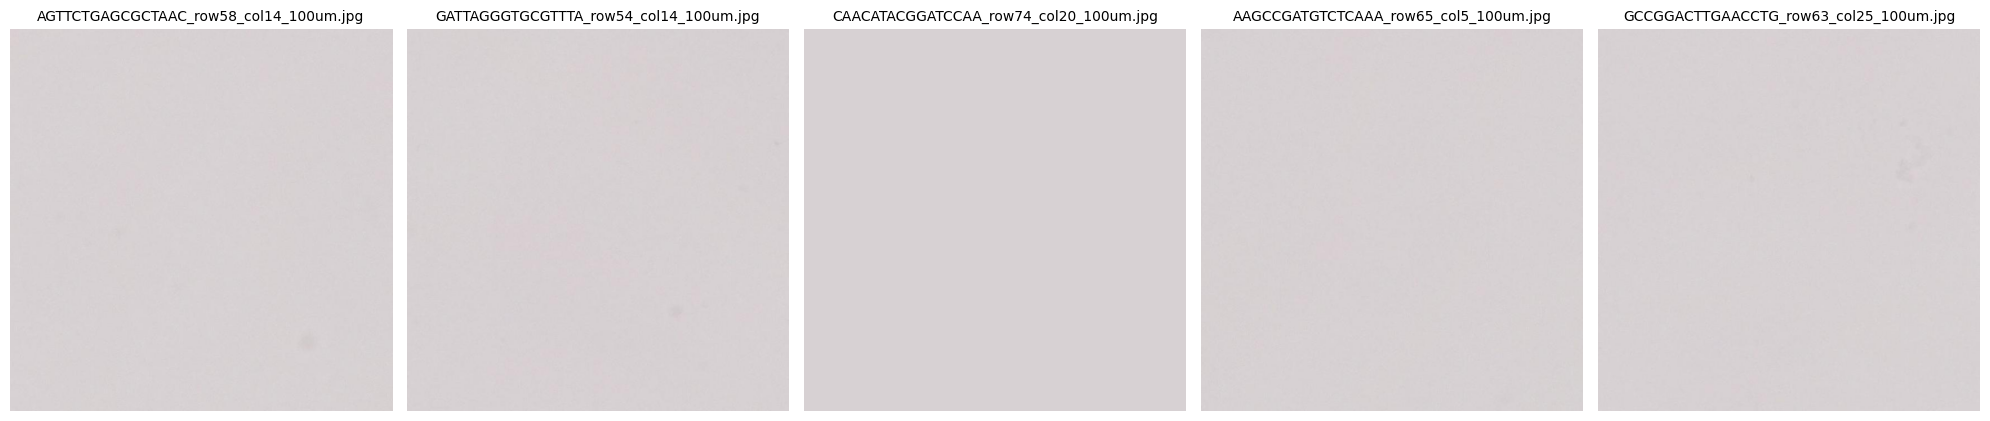

In [ ]:
five_rand_empty_images = []

with open(normalisation_fails_file, "r") as o:
    header = o.readline()  # Skip the header
    the_others = o.readlines()[:-1]  # Exclude the empty last line

# Strip newline characters and randomly select 5 file names
file_names = [line.strip() for line in the_others]
five_rand_empty_images = random.sample(file_names, 5)
print(five_rand_empty_images)

# Plot the images side by side
fig, axes = plt.subplots(1, 5, figsize=(20, 5))  # 1 row, 5 columns

for ax, file_name in zip(axes, five_rand_empty_images):
    image_path = os.path.join(INPUT_FOLDER, file_name)

    # Check if the image exists
    if not os.path.exists(image_path):
        print(f"Image not found: {file_name}")
        ax.axis("off")
        ax.set_title("Missing Image")
        continue

    # Try loading and displaying the image
    try:
        img = Image.open(image_path)  # Open the image
        ax.imshow(img)
        ax.axis("off")  # Turn off the axis
        ax.set_title(file_name, fontsize=10)  # Optional: Set the title with the filename
    except Exception as e:
        print(f"Error loading image {file_name}: {e}")
        ax.axis("off")
        ax.set_title("Error")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
#plt.savefig("output.png")

---
**Saving the output**

In [6]:
# Save package versions to a .txt file
env_name = subprocess.check_output(['echo $CONDA_PREFIX'], shell=True, text=True)
env_name = env_name.split('/')[-1]

with open("requirements_for_torchvahadane_env.txt", "w") as f:
    subprocess.run(["pip", "freeze"], stdout=f)

---
**Functions not used anymore:**

In [ ]:
# normalisation on gpu
gpu = "cuda"
# Load and convert to NumPy array (for OpenCV compatibility)
#target = cv2.imread(TARGET_IMAGE_PATH)
#target = cv2.cvtColor(target, 4)
target = Image.open(TARGET_IMAGE_PATH).convert("RGB")
target = torch.Tensor(np.array(target))  # Convert to PyTorch tensor

# Transpose dimensions to match Kornia's expected format
target = target.permute(2, 0, 1).to(gpu)#.unsqueeze(0)  # don't add a batch dimension: (1, 3, H, W)
#print(target.size())
#target = torch.Tensor(np.array(target))  
#target = np.array(target)  
#temp = kornia.color.rgb_to_lab(target)
#temp.save("reference_images/temp.png")
#target = torch.from_numpy(target_array)

# Initialize the normalizer
normalizer = TorchVahadaneNormalizer(device=gpu,
                                     staintools_estimate=False
                                     )
normalizer.stain_extractor.luminosity_threshold = 0.9 # increasing the mask sensitivity. Normally is 0.8
normalizer.fit(target)  # Pass NumPy array for compatibility

normalisation_fails_file = f"{output_folder}/0_failed_to_normalised.txt"

# Process each image in the input folder
with open(normalisation_fails_file, "w") as file:
    file.write("The following tiles haven't normalised:\n")

    for filename in os.listdir(INPUT_FOLDER):
        image_path = os.path.join(INPUT_FOLDER, filename)



        # Load and preprocess the image
        #img = cv2.imread(image_path)
        #img = cv2.cvtColor(img, 4)
        img = Image.open(image_path).convert("RGB")
        img = torch.Tensor(np.array(img))  # Convert to PyTorch tensor

        # Transpose dimensions to match Kornia's expected format
        img = img.permute(2, 0, 1).to(gpu)#.unsqueeze(0)
        #img = np.array(img)  # Convert to tensor and normalize to [0, 1]
        #img = torch.from_numpy(img_array)



        try:
            # Perform normalization
            img_normed_tensor = normalizer.transform(img)

            # Check output dimensions and ensure only 3 channels are retained
            #if img_normed_tensor.size(0) > 3:
            #    img_normed_tensor = img_normed_tensor[:3, :, :]

            # Convert the normalized image back to PIL format
            img_normed_pil = torchvision.transforms.functional.to_pil_image(img_normed_tensor)

            # Save the normalized image
            output_path = os.path.join(output_folder, f"{os.path.splitext(filename)[0]}_{normalisation_method}_gpu.jpg")
            img_normed_pil.save(output_path)

            #print(f"Normalized image saved to: {output_path}")
        
        except Exception as e:
            file.write(f"{filename}\n")
            #print(f"Error processing {filename}: {e}")


In [ ]:
# normalisation on cpu
# Load and preprocess the target image
target = Image.open(TARGET_IMAGE_PATH).convert("RGB")
target_array = np.array(target)  # Convert to NumPy array (for OpenCV compatibility)

# Initialize the normalizer
normalizer = TorchVahadaneNormalizer(device='cuda', staintools_estimate=True)
normalizer.fit(target_array)  # Pass NumPy array for compatibility

# Process each image in the input folder
for filename in os.listdir(INPUT_FOLDER):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # Checking for images
        image_path = os.path.join(INPUT_FOLDER, filename)

        # Load and preprocess the image
        img = Image.open(image_path).convert("RGB")
        img_array = np.array(img)  # Convert to NumPy array (for OpenCV compatibility)

        # Perform normalization
        img_normed_tensor = normalizer.transform(img_array, return_mask=False)

        # Convert the normalized tensor to a NumPy array
        img_normed_array = img_normed_tensor.cpu().numpy().clip(0, 255).astype(np.uint8)

        # Convert the normalized image back to PIL format
        img_normed_pil = Image.fromarray(img_normed_array)

        # Save the normalized image
        output_path = os.path.join(output_folder, f"{os.path.splitext(filename)[0]}_{normalisation_method}_cpu.png") # or .jpg (maybe it's better)
        img_normed_pil.save(output_path)

        print(f"Normalized image saved to: {output_path}")